In [1]:
import numpy as np
import operator
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA

# Data input

In [2]:
df_policy = pd.read_excel(r"../../02_Data/03_Policy/COVID_StatePolicy_final.xlsx")
df_case = pd.read_csv(r"../../02_Data/01_COVID/covid_us_county.csv")
df_case.dropna(inplace=True)

Import socio-demographic data (codes from Yuchen)

In [3]:
df_sd=pd.read_csv(r"../../02_Data/02_SociaDemographics/us_final.csv",index_col=0)
df_sd = df_sd.reset_index()

df_sd.loc[549,'ChildPoverty'] = df_sd[df_sd["state"]=="Hawaii"]["ChildPoverty"].median()
df_missing_crime = df_sd[df_sd["crime_rate_per_100000"].isnull()]
df_missing_crime_num = df_missing_crime.groupby("state")["state"].count()

crime_columns = ["crime_rate_per_100000","IDNO","Crime_CPOPARST","Crime_CPOPCRIM","Crime_AG_OFF","Crime_COVIND","Crime_MODINDX","Crime_MURDER","Crime_RAPE","Crime_ROBBERY","Crime_AGASSLT","Crime_BURGLRY","Crime_LARCENY","Crime_MVTHEFT","Crime_ARSON"]
state_list = ["Alaska","New Mexico","South Dakota"]
for state in state_list:
    index_list = df_missing_crime[df_missing_crime['state']==state]["index"].tolist()
    for crime in crime_columns:
        for index in index_list:
            df_sd.loc[index-1,crime] = df_sd[df_sd['state']==state][crime].median()

Calculate case growth rate (codes from Yuchen)

In [4]:
mData1 = []
df_case['fips'] = df_case.fips.astype(int)
df_sir = df_case.copy()
fips = list(set(df_sir['fips']))
for fip in tqdm(fips):
    df = df_sir[(df_sir['fips']==fip)]
    
    df = df[df['cases']>=5]
    df = df.reset_index(drop=True)
    df = df.reset_index()

    df = df.to_dict("records")
    # 7 day Moving average
    for i in range(len(df)-6):
        mdf = df[i:i+7]
        mdf_case = [m['cases'] for m in mdf]
        mdf_death = [m['deaths'] for m in mdf]
        df[i+3]['cases_7'] = np.sum(mdf_case)/7
        df[i+3]['deaths_7'] = np.sum(mdf_death)/7
        df[i+3]['day_index'] = df[i+3]['index']
        mData1.append(df[i+3])
    
# The log value
for i in range(len(mData1)-1):
    mData1[i+1]['delta_case'] = np.log(mData1[i+1]['cases_7']) - np.log(mData1[i]['cases_7'])
    pass
del mData1[0]

100%|█████████████████████████████████████████████████████████████████████████████| 3241/3241 [00:24<00:00, 133.59it/s]


In [5]:
df_case_delta = pd.DataFrame(mData1)
df_case_delta = df_case_delta[(df_case_delta['cases_7']>=10)&(df_case_delta['date']>="2020-03-01")&(df_case_delta['delta_case']>0)]
df_case_delta.dropna(inplace=True)

In [6]:
df_case_delta = pd.merge(df_case_delta,df_policy,on=['state_code','state'],how='left')

In [7]:
df_case_delta.head()

,index,fips,county,state,lat,long,date,cases,state_code,deaths,...,close_restaurant,close_gym,close_theater,close_bar,reopen_business,reopen_restaurant,reopen_gym,reopen_theater,reopen_bar,facemask
0,7,41001,Baker,Oregon,44.709156,-117.674988,2020-07-11,11,OR,0,...,2020-03-18,2020-03-24,2020-03-24,2020-03-17,2020-05-15,2020-06-19,2020-06-19,NaT,2020-06-19,2020-07-01
1,8,41001,Baker,Oregon,44.709156,-117.674988,2020-07-12,12,OR,0,...,2020-03-18,2020-03-24,2020-03-24,2020-03-17,2020-05-15,2020-06-19,2020-06-19,NaT,2020-06-19,2020-07-01
2,9,41001,Baker,Oregon,44.709156,-117.674988,2020-07-13,12,OR,0,...,2020-03-18,2020-03-24,2020-03-24,2020-03-17,2020-05-15,2020-06-19,2020-06-19,NaT,2020-06-19,2020-07-01
3,10,41001,Baker,Oregon,44.709156,-117.674988,2020-07-14,12,OR,0,...,2020-03-18,2020-03-24,2020-03-24,2020-03-17,2020-05-15,2020-06-19,2020-06-19,NaT,2020-06-19,2020-07-01
4,11,41001,Baker,Oregon,44.709156,-117.674988,2020-07-15,13,OR,0,...,2020-03-18,2020-03-24,2020-03-24,2020-03-17,2020-05-15,2020-06-19,2020-06-19,NaT,2020-06-19,2020-07-01


# Define second wave
Eyeballing approach.
<p> Method 1: look at the trend of the total cases in US.

In [8]:
# calculate new cases 
df_case['new_cases']=df_case['cases'].groupby(df_case['fips']).diff().fillna(0)
df_case['new_cases']=df_case['new_cases'].clip(lower=0)
    ## Calculate 7-day moving average
df_case['cases_7day_ave'] = df_case.groupby('fips', as_index=False)['new_cases'].rolling(window=7,center=True).mean().fillna(0).reset_index(
    0, drop=True)

# calculate total new covid cases in US
us_total=df_case.groupby('date', as_index=False).agg({"cases_7day_ave":"sum"})

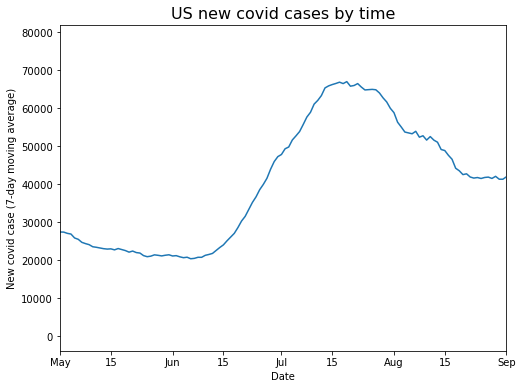

In [9]:
us_total['date']=pd.to_datetime(us_total['date'])

plt.figure(figsize=(8,6))
g=sns.lineplot(x="date", y="cases_7day_ave",
             data=us_total)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlim(pd.to_datetime("2020-05-01"),pd.to_datetime("2020-09-01"))
g.set_xlabel('Date')
g.set_ylabel('New covid case (7-day moving average)')
plt.title("US new covid cases by time",fontsize=16)
plt.show()

Method 2: look at the case growth rate.

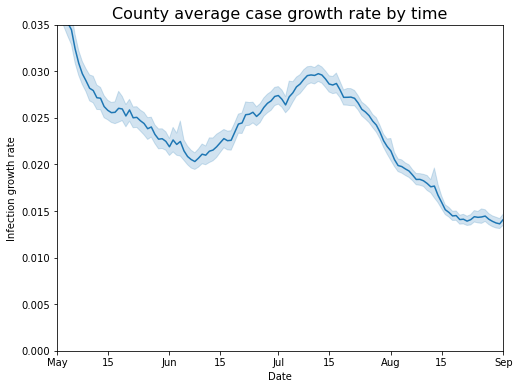

In [10]:
# case growth rate
df_case_delta['date']=pd.to_datetime(df_case_delta['date'])

plt.figure(figsize=(8,6))
g=sns.lineplot(x="date", y="delta_case",
             data=df_case_delta)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlim(pd.to_datetime("2020-05-01"),pd.to_datetime("2020-09-01"))
g.set_ylim(0,0.035)
g.set_xlabel('Date')
g.set_ylabel('Infection growth rate')
plt.title("County average case growth rate by time",fontsize=16)
plt.show()

Given the trend shown in these two figures, we define the beginning of second wave as June 15, and use the mobility data between May 15 to June 15 to predict the average COVID case growth June 15 - July 15 in each county.

# Prepare predictors

(1) Re-open early: 0-1, if stop stay-at-home order before May 15 defines as 1.
<p> (2) Face mask wearing habit: continuous score. Assign score 1 to 5 for "never" to "always" and calculate the score for each county. 
<p> (3) Socio-demographic characteristics of the county
<p> (4) Mobility by places May 15- Jun 15
<p> (5) Average temperature of May-June.

In [11]:
print(list(df_case_delta.columns))

['index', 'fips', 'county', 'state', 'lat', 'long', 'date', 'cases', 'state_code', 'deaths', 'cases_7', 'deaths_7', 'day_index', 'delta_case', 'state_fips', 'emergency', 'stay_at_home', 'gathering', 'end_stay_at_home', 'close_school', 'close_nonessential_business', 'close_restaurant', 'close_gym', 'close_theater', 'close_bar', 'reopen_business', 'reopen_restaurant', 'reopen_gym', 'reopen_theater', 'reopen_bar', 'facemask']


In [12]:
# reopen time
df_policy['reopen_early']=[1 if pd.to_datetime(x)<pd.to_datetime('2020-05-15')
                        else 0 for x in df_policy['end_stay_at_home']]

In [13]:
# facemask
df_facemask = pd.read_csv(r"../../02_Data/07_Facemask/county_facemask.csv",index_col=0)
df_facemask['facemask_score']=1*df_facemask['facemask_never']+2*df_facemask['facemask_rarely']+3*df_facemask['facemask_sometimes']+4*df_facemask['facemask_frequently']+5*df_facemask['facemask_always']
df_facemask['facemask_score'].describe()

count    3142.000000
mean        3.981097
std         0.413002
min         2.433000
25%         3.682000
50%         3.992000
75%         4.291750
max         4.849000
Name: facemask_score, dtype: float64

In [14]:
# average case growth Jun 15 to Jul 15
df_case_secondwave=df_case_delta[(df_case_delta['date']>="2020-06-15")&(df_case_delta['date']<="2020-07-15")]
df_casegrowth=df_case_secondwave.groupby('fips', as_index=False).agg({"delta_case":"mean"})
df_casegrowth['delta_case'].describe()

count    2762.000000
mean        0.028772
std         0.023138
min         0.000434
25%         0.012683
50%         0.023698
75%         0.038466
max         0.249496
Name: delta_case, dtype: float64

In [15]:
# weather
df_weather = pd.read_csv(r"../../02_Data/06_Weather/county_av_tem.csv",index_col=0)
df_weather_sub=df_weather[(df_weather['month']>=5)&(df_weather['month']<=6)]
df_weather_sub['av_tem'].describe()

count    6272.000000
mean       66.925797
std         8.832627
min        28.900000
25%        59.700000
50%        68.000000
75%        74.300000
max        87.300000
Name: av_tem, dtype: float64

In [ ]:
# mobility
df_mob = pd.read_csv("../../02_Data//05_Mobility/2020_US_Region_Mobility_Report.csv")
df_mob = df_mob.drop(labels='census_fips_code', axis=1)
df_mob['metro_area'].notnull().values.any()